In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Multi-class text classification using BERT and undersampling

In [1]:
#https://github.com/dtolk/multilabel-BERT/blob/master/notebooks/multi_label_text_classification_BERT.ipynb
#https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75#:~:text=For%20imbalanced%20datasets%2C%20where%20number,the%20positive%20and%20negative%20classes.

!pip install tensorflow
import tensorflow as tf
!nvidia-smi


Mon Sep 16 19:44:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install transformers

In [3]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
import re
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
from google.colab import drive
drive.mount('/content/drive')
import glob
file_names = glob.glob('/content/drive/MyDrive/Twitter_covid_classification/Annotated Data/*.csv')
print(file_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/Twitter_covid_classification/Annotated Data/CNN_tweets_unique.csv', '/content/drive/MyDrive/Twitter_covid_classification/Annotated Data/CDCFLu_tweets_unique.csv', '/content/drive/MyDrive/Twitter_covid_classification/Annotated Data/CDCtravel_tweets_unique_.csv', '/content/drive/MyDrive/Twitter_covid_classification/Annotated Data/CDCemergency_tweets_unique.csv', '/content/drive/MyDrive/Twitter_covid_classification/Annotated Data/CDCgov_tweets_unique.csv']


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:

df_data = []
for file_name in file_names:
  temp = pd.read_csv(file_name)
  if 'CDCFLu' in file_name:
    temp = temp.head(50)
  else:
    temp = temp.head(499)
  df_data.append(temp)
df_data = pd.concat(df_data)
print(df_data.shape)
#df_data=df_data.head(500)
print(df_data["Category"].unique())
def clean_text(text):
    text = re.sub(r'RT\s@\w+:\s', '', text) # remove retweet text
    text = re.sub(r'https?:\/\/\S+', '', text) # remove URLs
    text = re.sub(r'&\w+;', '', text) # remove HTML entities
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\W+', ' ', text) # remove special characters
    text = text.lower() # convert to lowercase
    return text

df_data["clean_text"] = df_data["text"].apply(clean_text)


(2046, 13)
[nan 'Outbreak' 'Vaccine; Outbreak' 'Outbreak; Prevention; Vaccine'
 'Outbreak; Vaccine' 'Outbreak; Symptoms' 'Outbreak; Prevention' 'Vaccine'
 'Prevention' 'Outbreak; Vaccine; Prevention' 'Vaccine; Prevention'
 'Vaccine, Prevention; Symptoms' 'Vaccine, Outbreak' 'Travel; Outbreak'
 'Travel' 'Prevention, Travel' 'Travel; Prevention' 'Prevention; Travel'
 'Symptoms' 'Prevention; Outbreak' 'Prevention: Travel'
 'Prevention; travel' 'Prevntion' 'Outbreak ' 'Vaccine, Travel'
 'Outbreak; Travel' 'outbreak' 'Travel; prevention' 'Travel; Symptoms'
 'Ountbreak' 'outbreak ' 'prevention' ' Outbreak; Prevention'
 ' Prevention' 'Outbrek; Symptoms' 'Outbreak; symptoms'
 'Outbreak; prevention' 'prevention; outbreak' 'Prevention; Outbreak '
 'Outbreak Prevention' 'outbreak, prevention' 'Prevention; outbreak'
 'outbreak; prevention' 'travel; prevention' 'Symptoms; Prevention'
 'Prevention, Outbreak' 'Outbreak; Awarness' 'Prevention; Awarness'
 'Symptoms, Awarness' 'Outbreak;Awareness' 'Outb

In [11]:
# Filtering the rare terms.
df_data_filtered = df_data.groupby("Category").filter(lambda x: len(x) >1)
df_data_filtered.shape
print(df_data_filtered["Category"])
df_data_filtered["Category"]=[''.join(i.split()).lower() for i in df_data_filtered["Category"]]

def filter_category(categories):
  #options = ['travel', 'outbreak','prevention','vaccine','symptoms']
  if ',' in categories:
    category_list = categories.split(',')
  elif ';' in categories:
    category_list = categories.split(';')
  else:
    category_list = [categories]

  #print(category_list)
  '''
  temp = []
  for item in category_list:
    item = item.strip().lower()
    if 'awarness' == item:
      continue
    temp.append(item.strip())
  #print('temp =', temp)
  '''
  return category_list

df_data_filtered["Category"] = df_data_filtered["Category"].apply(filter_category)

labels=[item for item in df_data_filtered["Category"]]



print(labels)



2                  Outbreak
4                  Outbreak
12        Vaccine; Outbreak
28        Outbreak; Vaccine
39                 Outbreak
               ...         
487    Prevention; Awarness
488              Prevention
490                Symptoms
492              Prevention
496                Symptoms
Name: Category, Length: 938, dtype: object
[['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'vaccine'], ['outbreak'], ['outbreak', 'symptoms'], ['outbreak', 'vaccine'], ['outbreak', 'vaccine'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['vaccine'], ['outbreak'], ['vaccine'], ['outbreak'], ['outbreak'], ['outbreak', 'vaccine'], ['outbreak', 'prevention'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccin

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
mlb = MultiLabelBinarizer()
a = mlb.fit_transform(labels)
pd.DataFrame(a, columns=mlb.classes_)
final_text=[text for text  in df_data_filtered["clean_text"]]

labels=[lab for lab  in a]

lab,c =np.unique(a, axis=0, return_counts=True)

print(lab,c)
print(mlb.classes_)
print("total",sum(c))
print(final_text[0])




[[0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 1 0 1 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]] [ 12 142  18 207   2  50   2 341  27   8  11 100   5  13]
['awarness' 'outbreak' 'prevention' 'symptoms' 'travel' 'vaccine']
total 938
b europe is now trading more goods with china than the united states a sign of how the pandemic is transforming the global economy the overall value of eu china goods trade last year was billion about billion more than between the eu and the us 


In [13]:
lnew=np.zeros((len(labels),5));
#print("before",labels)
for i,l in enumerate(labels):
  lnew[i,:]=l[1:]
final_label=lnew
'''
outbreak=[]
prevention=[]
combined=[]
travel=[]
resources=[]
o_y=[]
p_y=[]
c_y=[]
t_y=[]
r_y=[]
for item,text in zip(final_label,final_text):
  if item[0]==1:
    outbreak.append(text)
    o_y.append([0,0])
  if item[1]==1:
    prevention.append(text)
    p_y.append([0,1])
  if item[2]==1 or item[4]==1:# consequences /resources
    combined.append(text)
    c_y.append([1,0])
  if item[3]==1:
    travel.append(text)
    t_y.append([1,1])
all_text=[]
all_text=outbreak[:366]+prevention+combined+travel

all_label=o_y[:366]+p_y+c_y+t_y
sel_labels,sel_counts=np.unique(np.asarray(all_label),axis=0,return_counts=True)
print(sel_labels,sel_counts)
print(len(all_text),sum(sel_counts))
'''

'\noutbreak=[]\nprevention=[]\ncombined=[]\ntravel=[]\nresources=[]\no_y=[]\np_y=[]\nc_y=[]\nt_y=[]\nr_y=[]\nfor item,text in zip(final_label,final_text):\n  if item[0]==1:\n    outbreak.append(text)\n    o_y.append([0,0])\n  if item[1]==1:\n    prevention.append(text)\n    p_y.append([0,1])\n  if item[2]==1 or item[4]==1:# consequences /resources\n    combined.append(text)\n    c_y.append([1,0])\n  if item[3]==1:\n    travel.append(text)\n    t_y.append([1,1])\nall_text=[]\nall_text=outbreak[:366]+prevention+combined+travel\n\nall_label=o_y[:366]+p_y+c_y+t_y\nsel_labels,sel_counts=np.unique(np.asarray(all_label),axis=0,return_counts=True)\nprint(sel_labels,sel_counts)\nprint(len(all_text),sum(sel_counts))\n'

In [ ]:
#print(combined)

In [14]:

# Hyperparameters
MAX_LEN = 20
TRAIN_BATCH_SIZE = 20
VALID_BATCH_SIZE = 20
TEST_BATCH_SIZE = 20
EPOCHS = 10
THRESHOLD = 0.5 # threshold for the sigmoid


In [15]:
from transformers import BertTokenizer, BertModel

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df)
        self.targets = target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [19]:
type(final_text), type(final_label)

(list, numpy.ndarray)

In [20]:
len(final_text), final_label.shape
# The error indicates that the 'final_label' array is multidimensional, which is causing an issue when creating the DataFrame.

#To resolve this issue, you need to ensure that the 'final_label' array is one-dimensional.
#Since 'final_label' is a numpy array, you can use the .flatten() method to convert it into a one-dimensional array.

# we cannot do this as flattening the labels will give some 4k rows which is not equal to number of final_text

(938, (938, 5))

In [55]:

test_split = 0.1
val_split=0.1

# Create DataFrame with final_text and final_label
df = pd.DataFrame({'txt': final_text, 'lab': final_label.tolist()})

# Initial train and test split
all_df, test_df = train_test_split(
    df,
    test_size=test_split,
    stratify=df['lab'].apply(lambda x: tuple(x)), # Use tuple of labels as strata
    random_state = 95
)
train_df, val_df = train_test_split(
    all_df,
    test_size=val_split,
    stratify=all_df['lab'].apply(lambda x: tuple(x)), # Use tuple of labels as strata
    random_state = 95
)

In [22]:
df.head()

,txt,lab
0,b europe is now trading more goods with china ...,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,b ryan reynolds and blake lively have once aga...,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,b states will receive more doses of covid vacc...,"[1.0, 0.0, 0.0, 0.0, 1.0]"
3,b here s what s in house democrats stimulus re...,"[1.0, 0.0, 0.0, 0.0, 1.0]"
4,b house democrats unveil trillion covid relief...,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [57]:


# Splitting the test set further into validation
# and new test sets.
print(test_df)

#val_df = test_df.sample(frac=0.5)

#test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
#print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

train_dataset = CustomDataset(np.asarray(train_df["txt"]), tokenizer, MAX_LEN, np.asarray(train_df["lab"]))

test_dataset = CustomDataset(np.asarray(test_df["txt"]), tokenizer, MAX_LEN, np.asarray(test_df["lab"]))
val_dataset = CustomDataset(np.asarray(val_df["txt"]), tokenizer, MAX_LEN, np.asarray(val_df["lab"]))
print(train_dataset)


                                                   txt  \
309  travel can put you at risk of getting or sprea...   
917  remember to practice every day foodsafety duri...   
572  homeless service providers planning and respon...   
77   b two new large scale coronavirus vaccination ...   
419  protect yourself from covid and other illnesse...   
..                                                 ...   
934   dyk itâ s not safe to put a mask on your pet ...   
557  does wearing a mask mean you donâ t have to pr...   
39   b a democratic new york assemblyman alleges go...   
610  to increase the use of face masks in public ac...   
176  travel increases your chances of getting and s...   

                           lab  
309  [0.0, 1.0, 0.0, 0.0, 0.0]  
917  [1.0, 0.0, 0.0, 0.0, 0.0]  
572  [1.0, 0.0, 0.0, 0.0, 0.0]  
77   [0.0, 0.0, 0.0, 0.0, 1.0]  
419  [1.0, 0.0, 0.0, 0.0, 0.0]  
..                         ...  
934  [0.0, 1.0, 0.0, 0.0, 0.0]  
557  [0.0, 1.0, 0.0, 0.0, 0.0]  
39   [

In [58]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(val_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [59]:
print(train_data_loader)

In [60]:
num_classes = len(train_dataset[0]['targets'])  # Get the number of classes from the dataset
print(num_classes)

5


In [61]:
class BERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, num_classes)  # Adjust output units

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output
model = BERTClass(num_classes)

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [63]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
# This version is more numerically stable than using a plain Sigmoid followed
# by a BCELoss as, by combining the operations into one layer,
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    device = outputs.device
    targets = targets.to(device)

    #weight = torch.tensor([1138/(366*4),  1138/(72*4), 1138/(200*4), 1138/(500*4)], device=device) # higher weight for class 1
    loss = nn.BCEWithLogitsLoss()
    return loss(outputs, targets)


In [135]:
from keras.optimizers import SGD




from keras import backend as K
# define the optimizer
optimizer = SGD(learning_rate=0.5)

In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

# Load the BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name)

# Compile the model
initial_learning_rate = 2e-5
optimizer = SGD(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# Example scheduler function
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * 0.1  # Reduce learning rate by a factor of 0.1 after 3 epochs

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Prepare your data (example)
train_encodings = train_data_loader
train_labels = tf.convert_to_tensor([1, 0])

# Train the model
model.fit(train_encodings['input_ids'], train_labels, epochs=5, callbacks=[lr_scheduler])


In [138]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        #optimizer.minimize(loss.item(),[1])
        # backward
        #optimizer.zero_grad()
        #loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        #optimizer.step()


        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [136]:
from sklearn.metrics import f1_score
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array
            v= f1_score(outputs, targets, average="macro")

    return float(correct_predictions)/num_samples, np.mean(losses), v

## Model Training

In [101]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
# Define the directory for saving model checkpoints
data_dir = "/content/drive/MyDrive/MultiLabel_BERT"
output_dir = os.path.join(data_dir, "output")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')


    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)

   # val_acc, val_loss, f = eval_model(test_data_loader, model, optimizer)
    print(train_acc)

#print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
   # history['val_acc'].append(val_acc)
    #history['val_loss'].append(val_loss)
    # Save the best model if the current accuracy is better than the previous best
    if train_acc > best_accuracy:
      model_checkpoint_path = os.path.join(output_dir, "MLTC_model_state.bin")
      torch.save(model.state_dict(), model_checkpoint_path)
      best_accuracy = train_acc



Epoch 1/10


  0%|          | 0/38 [00:00<?, ?it/s]

AttributeError: module 'keras.api.backend' has no attribute 'set_value'

In [91]:
import matplotlib.pyplot as plt

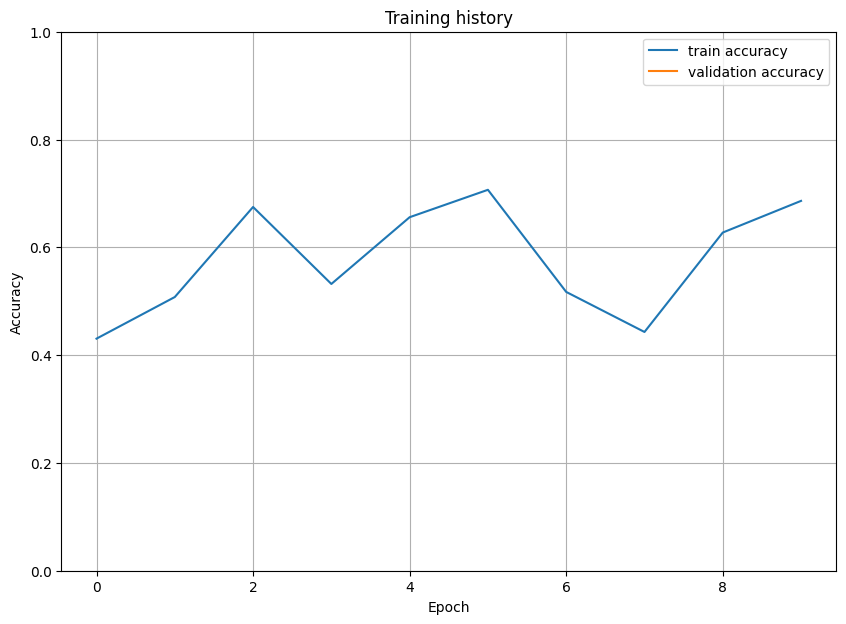

In [92]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the model

In [93]:
# Loading pretrained model (best model)
model = BERTClass(num_classes)
model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))
model = model.to(device)

<ipython-input-93-469229f6407a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))


In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [95]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    targets = []
    losses = []

    with torch.no_grad():
        for data in dataloader:
            # Move input data to the appropriate device (GPU or CPU)
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target = data['targets'].to(device)

            # Perform forward pass
            output = model(input_ids, attention_mask, token_type_ids)

            # Calculate loss
            loss = loss_fn(output, target)
            losses.append(loss.item())

            # Apply sigmoid activation and round to get predictions
            prediction = torch.sigmoid(output).cpu().numpy().round()
            predictions.extend(prediction)
            targets.extend(target.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(targets, predictions)

    # Calculate precision, recall, and F1-score
    precision = precision_score(targets, predictions, average='micro')
    recall = recall_score(targets, predictions, average='micro')
    f1_micro = f1_score(targets, predictions, average='micro')
    f1_macro = f1_score(targets, predictions, average='macro')

    return accuracy, precision, recall, f1_micro, f1_macro, np.mean(losses)



In [96]:
# Assuming you have a validation dataloader named 'test_data_loader'
accuracy, precision, recall, f1_micro, f1_macro, val_loss = evaluate_model(model, test_data_loader)

In [97]:
# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("MicroAvg FScore:", f1_micro * 100)
print("MacroAvg FScore:", f1_macro * 100)
print("Accuracy:", accuracy * 100)
print("Validation Loss:", val_loss)

Precision: 0.03723404255319149
Recall: 0.06140350877192982
MicroAvg FScore: 4.635761589403973
MacroAvg FScore: 2.869766463286345
Accuracy: 0.0
Validation Loss: 5.704584980010987


In [41]:
# Evaluate the model using the test data
v = eval_model(test_data_loader, model, optimizer)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-

In [45]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
print("acc,loss,fscore",v)

acc,loss,fscore (0.9085106382978724, 0.27403777092695236, 0.5714285714285714)


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions -
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


In [49]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [50]:
# sanity check
predictions.numpy()

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0.

In [81]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:188 
predictions:torch.Size([188, 5]) 
prediction_probs:torch.Size([188, 5]) 
target_values:torch.Size([188, 5])


In [82]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       100
           1       0.76      0.86      0.81        73
           2       1.00      0.33      0.50         6
           3       0.84      0.88      0.86        41
           4       0.60      0.86      0.71         7

   micro avg       0.79      0.84      0.82       227
   macro avg       0.80      0.75      0.74       227
weighted avg       0.80      0.84      0.81       227
 samples avg       0.83      0.86      0.83       227



In [ ]:
# import seaborn as sns
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True category')
#     plt.xlabel('Predicted category');

In [ ]:
# cm = confusion_matrix(target_values, predictions)
# df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
# show_confusion_matrix(df_cm)

## Predicting on raw text

In [ ]:
# raw text
raw_text = "Measurement of D-meson production as a function of charged-particle multiplicity in proton--proton collisions at s√=13 TeV with ALICE at the LHC."

In [ ]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

In [ ]:
# Correctly identified the topic of the paper: High energy physics
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")